In [1]:
# updated version to attempt to increase accuracy by reducing the number of dense layers following the resnet architecture
# performance increase was not evident

import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

TRAIN_DIR = 'data/train/*'
TEST_DIR = 'data/test/*'
IMG_SIZE = 300
IMG_DIM = (IMG_SIZE, IMG_SIZE)

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, 'resnet')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    return word_label

In [3]:
train_files = glob.glob(TRAIN_DIR) 
train_imgs = []
for index, item in tqdm(enumerate(train_files)):
    if index < 10000:
        train_imgs.append(img_to_array(load_img(item, target_size=IMG_DIM)))
    else:
        pass
    
validation_imgs = []
for index, item in tqdm(enumerate(train_files)):
    if index > 12000 and index < 12500:
        validation_imgs.append(img_to_array(load_img(item, target_size=IMG_DIM)))
    else:
        pass

25000it [00:12, 1930.33it/s]
25000it [00:01, 21948.85it/s] 


In [4]:
train_imgs = np.array(train_imgs)
validation_imgs = np.array(validation_imgs)

In [5]:
train_labels = []
for index, item in tqdm(enumerate(train_files)):
    if index < 10000:
        train_labels.append(item.split('/')[-1].split('.')[0].strip())
    else:
        pass
    
validation_labels = []
for index, item in tqdm(enumerate(train_files)):
    if index > 12000 and index < 12500:
        validation_labels.append(item.split('/')[-1].split('.')[0].strip())
    else:
        pass

25000it [00:00, 1883387.52it/s]
25000it [00:00, 4791956.86it/s]


In [6]:
train_imgs_scaled = train_imgs.astype('float32')
train_imgs_scaled /= 255

validation_imgs_scaled = validation_imgs.astype('float32')
validation_imgs_scaled /= 255

(300, 300, 3)
cat
(300, 300, 3)
cat


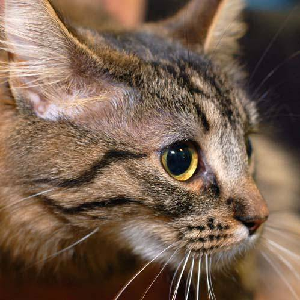

In [19]:
print(train_imgs[257].shape)
print(train_labels[257])

print(validation_imgs[255].shape)
print(validation_labels[255])

array_to_img(validation_imgs[255])

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

In [18]:
print(train_labels_enc[257])
print(validation_labels_enc[255])

0
0


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc,batch_size=32)
val_generator = validation_datagen.flow(validation_imgs, validation_labels_enc, batch_size=32)

In [20]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))

for layer in restnet.layers:
    layer.trainable = False

In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(restnet)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 204800)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               104858112 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 128,446,337
Trainable params: 104,858,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
history = model.fit(train_generator, batch_size=32, epochs=3, validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/3


2022-08-19 00:54:49.346189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 8.8731 - accuracy: 0.5028

2022-08-19 00:58:03.528316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 205s 646ms/step - loss: 8.8731 - accuracy: 0.5028 - val_loss: 0.6935 - val_accuracy: 0.4890
Epoch 2/3
313/313 [==============================] - 236s 754ms/step - loss: 0.7873 - accuracy: 0.5028
Epoch 3/3
297/313 [===========================>..] - ETA: 12s - loss: 0.7918 - accuracy: 0.5036

In [ ]:
model.save('resnetworkplease')